In [2]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install natasha

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/34.4 MB ? eta -:--:--
    --------------------------------------- 0.8/34.4 MB 5.6 MB/s eta 0:00:07
   -- ------------------------------------- 2.4/34.4 MB 6.7 MB/s eta 0:00:05
   ----- ---------------------------------- 4.5/34.4 MB 8.9 MB/s eta 0:00:04
   ----- ---------------------------------- 4.5/34.4 MB 8.9 MB/s eta 0:00:04
   ----- ---------------------------------- 4.5/34.4 MB 8.9 MB/s eta 0:00:04
   ----- ---------------------------------- 4.5/34.4 MB 8.9 MB/s eta 0:00:04
   ----- ---------------------------------- 4.5/34.4 MB 8.9 MB/s eta 0:00:04
   ----- ---------------------------------- 4.5/34.4 MB 8.9 MB/s eta 0:00:04
   ----- ---------------------------------- 4.5/34.4 MB 8.9 MB/s eta 0:00:04
   ----- ---------------------------------- 4.5/34.4 MB 8

In [2]:
pip install statsforecast 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install transformers xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.4 MB 3.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/10.4 MB 2.6 MB/s eta 0:00:04
   ------ --------------------------------- 1.6/10.4 MB 2.9 MB/s eta 0:00:04
   -------- ------------------------------- 2.1/10.4 MB 2.9 MB/s eta 0:00:03
   ----------- ---------------------------- 2.9/10.4 MB 2.9 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 2.8 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 2.8 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 2.8 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 2.8 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 2.8 MB/s eta 0:00:03
   ------------ --------------------------- 3.1/10.4 MB 2.8 MB/s eta 0:00:03
   --

In [5]:
import re
import warnings

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from natasha import Doc, MorphVocab, NewsEmbedding, NewsMorphTagger, Segmenter
from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from xgboost import XGBClassifier

nltk.download("stopwords")

warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cristin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Загрузка датасетов и подготовка данных

In [8]:
# Загружаем курс доллара к рублю, преобразуем дату
df_time = pd.read_csv("usdrub_d.csv", parse_dates=["Date"])
df_time["date"] = df_time["Date"].dt.date

# Загружаем датасет новостей Lenta.ru и преобразуем в DataFrame
dataset = load_dataset("data-silence/lenta.ru_2-extended")
df = dataset["train"].to_pandas()

# Преобразуем формат даты и фильтруем по наличию тегов
df["date"] = pd.to_datetime(df["date"]).dt.date
df_filtered = df.dropna(subset=["tags"])
df_filtered = df_filtered[df_filtered["tags"].isin(["Экономика", "Политика"])]

# Объединяем заголовки новостей по дате в один текст
grouped = (
    df_filtered.groupby("date")["title"]
    .apply(lambda texts: " ".join(texts))
    .reset_index()
)

# Строим полный диапазон дат и объединяем с новостями, где нет — подставляем заглушку
full_date_range = pd.date_range(
    start=grouped["date"].min(), end=grouped["date"].max(), freq="D"
).date
df_news_full = pd.DataFrame({"date": full_date_range}).merge(
    grouped, on="date", how="left"
)
df_news_full["title"] = df_news_full["title"].fillna("нет новостей")

# Фильтруем курс по датам новостей и оставляем только дату и цену закрытия
df_time_filtered = df_time[
    df_time["date"].between(grouped["date"].min(), grouped["date"].max())
]
df_time_filtered = df_time_filtered[["date", "Close"]]

''' # Объединяем новости и курсы валют по дате
df_merged = pd.merge(df_news_full, df_time_filtered, on="date", how="inner")

# Добавляем целевую переменную: 1, если курс вырос на следующий день
df_merged["target"] = (df_merged["Close"].shift(-1) > df_merged["Close"]).astype(int)

# Оставляем только нужные столбцы
df_final = df_merged[["date", "title", "Close", "target"]]

# Преобразуем дату обратно в формат datetime
df_final["date"] = pd.to_datetime(df_final["date"]) '''

# Объединяем новости и курсы валют по дате
df_merged = pd.merge(df_news_full, df_time_filtered, on="date", how="inner")

# Вычисляем изменение через 3 дня
df_merged["pct_change_3d"] = (df_merged["Close"].shift(-3) - df_merged["Close"]) / df_merged["Close"]

# Целевая переменная: 1 — рост > 0.5%, 0 — падение > 0.5%, остальное — NaN
threshold = 0.005
df_merged["target"] = np.where(df_merged["pct_change_3d"] > threshold, 1,
                        np.where(df_merged["pct_change_3d"] < -threshold, 0, np.nan))

# Оставляем только даты с чётким направлением движения (убираем нейтральные)
df_final = df_merged[~df_merged["target"].isna()].copy()
df_final["target"] = df_final["target"].astype(int)
df_final = df_final[["date", "title", "Close", "target"]]
df_final["date"] = pd.to_datetime(df_final["date"])


In [9]:
df_final.head()

,date,title,Close,target
2,2019-12-18,Глава Генштаба оценил вероятность начала крупн...,62.5908,0
3,2019-12-19,Путин назвал подвигом жизнь россиян в 1990-х П...,62.3800,0
12,2020-01-06,Генсек ООН заявил о максимальном уровне геопол...,61.7868,0
13,2020-01-07,В США объяснили путаницу с выводом войск из Ир...,61.9555,0
14,2020-01-08,Путин рассказал о попытках помешать отношениям...,61.5955,0


In [10]:
print(df_final["target"].value_counts(normalize=True).rename(lambda x: f"class {x}"))

target
class 1    0.523039
class 0    0.476961
Name: proportion, dtype: float64


In [11]:
counts = df_final["target"].value_counts()
percent = df_final["target"].value_counts(normalize=True).round(3)
balance_df = pd.DataFrame({"count": counts, "percent": percent})
print(balance_df)

        count  percent
target                
1         420    0.523
0         383    0.477


## Функция для метрик

In [12]:
def evaluate_classifier_metrics(y_true, y_pred, y_score=None):
    """
    Выводит classification report и график ROC-кривой (если y_score передан).

    Parameters:
    - y_true : array-like — истинные метки классов (0 или 1)
    - y_pred : array-like — предсказанные метки классов (0 или 1)
    - y_score : array-like or None — оценки уверенности модели (например, вероятности)
    """

    # Печатаем сводку метрик классификации (precision, recall, f1 и т.д.)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    # Если передан y_score, строим ROC-кривую и вычисляем AUC
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_true, y_score)  # координаты ROC-кривой
        auc_score = roc_auc_score(y_true, y_score)  # площадь под кривой (AUC)

        # Отрисовка графика
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.3f}")
        plt.plot([0, 1], [0, 1], "k--", alpha=0.4)  # линия случайной модели
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("📈 ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Модели для временного ряда

## Arima

In [13]:
# === Подготовка данных ===

df = df_final[["date", "Close"]].copy()  # Берем только дату и цену закрытия

df = df.rename(
    columns={"date": "ds", "Close": "y"}
)  # Переименование под формат StatsForecast
df["ds"] = pd.to_datetime(df["ds"])  # Преобразуем дату в формат datetime

# Добавляем уникальный идентификатор временного ряда (требование StatsForecast)
df["unique_id"] = "rub_usd"

# === Обучение модели ===

# Инициализация модели AutoARIMA с дневной сезонностью и параллельной обработкой
model = StatsForecast(models=[AutoARIMA(season_length=5)], freq="D", n_jobs=-1)

# Кросс-валидация: прогнозируем на один день вперед по скользящему окну, не переобучаясь
cv_df = model.cross_validation(
    df=df,
    h=1,  # горизонта прогноза: 1 день
    step_size=1,  # шаг окна: 1 день
    test_size=200,  # длина тестовой выборки: 200 дней
    refit=False,  # модель не переобучается на каждом окне
)

📋 Classification Report:

              precision    recall  f1-score   support

           0      0.475     0.552     0.511        87
           1      0.602     0.527     0.562       112

    accuracy                          0.538       199
   macro avg      0.539     0.539     0.536       199
weighted avg      0.547     0.538     0.539       199



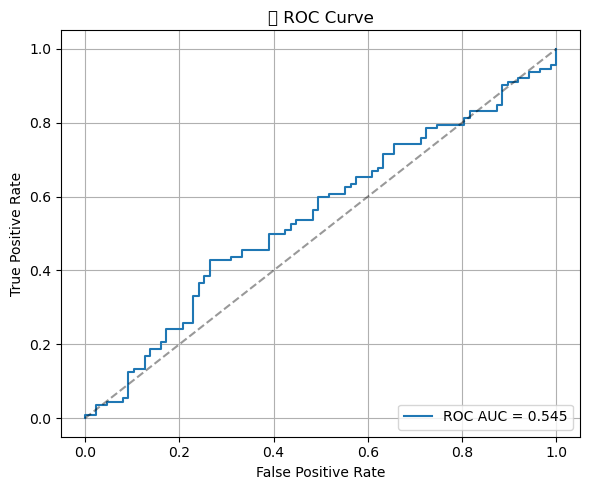

In [14]:
# Объединяем исходные данные с прогнозами модели по дате
cv_df = df_final.merge(
    cv_df[["ds", "AutoARIMA"]], left_on=["date"], right_on=["ds"], how="left"
)

# Преобразуем прогноз в бинарную метку: 1, если прогноз выше текущей цены
cv_df["y_pred"] = (cv_df["AutoARIMA"].shift(-1) > cv_df["Close"]).astype(int)

# Оцениваем "уверенность" модели — разница между прогнозом и текущей ценой
cv_df["y_score"] = cv_df["AutoARIMA"].shift(-1) - cv_df["Close"]

# Удаляем последнюю строку с пропущенным значением целевой переменной
cv_clean = cv_df.dropna()

# Выводим метрики классификации и ROC-кривую для оценки модели
evaluate_classifier_metrics(
    y_true=cv_clean["target"], y_pred=cv_clean["y_pred"], y_score=cv_clean["y_score"]
)

### Подготовка для моделей ML классификации 

In [15]:
# Копируем исходный датафрейм с ценой и целевой переменной
df_time = df_final[["Close", "target"]].copy()

# Добавляем лаги: текущая, вчерашняя и позавчерашняя цена
df_time["lag_1"] = df_time["Close"]
df_time["lag_2"] = df_time["Close"].shift(1)
df_time["lag_3"] = df_time["Close"].shift(2)

# Скользящее среднее за последние 5 дней
df_time["sma_5"] = df_time["Close"].rolling(window=5).mean()

# Изменение курса за последнюю неделю (5 дней)
df_time["delta_week"] = df_time["Close"] - df_time["Close"].shift(5)

# Удаляем строки с пропущенными значениями, возникшими из-за лагов и скользящего среднего
df_time = df_time.dropna().reset_index(drop=True)

# Выводим полученный датафрейм
display(df_time)

# Определяем признаки и целевую переменную для обучения модели
X = df_time[["lag_1", "lag_2", "lag_3", "sma_5", "delta_week"]]
y = df_time["target"]

,Close,target,lag_1,lag_2,lag_3,sma_5,delta_week
0,60.9418,1,60.9418,61.5955,61.9555,61.73192,-1.6490
1,61.2725,1,61.2725,60.9418,61.5955,61.51042,-1.1075
2,61.4780,1,61.4780,61.2725,60.9418,61.44866,-0.3088
3,61.6000,1,61.6000,61.4780,61.2725,61.37756,-0.3555
4,62.0285,1,62.0285,61.6000,61.4780,61.46416,0.4330
...,...,...,...,...,...,...,...
793,83.5000,1,83.5000,86.5000,89.0250,87.38000,-6.8750
794,87.1850,1,87.1850,83.5000,86.5000,87.08200,-1.4900
795,89.0000,0,89.0000,87.1850,83.5000,87.04200,-0.2000
796,87.4500,0,87.4500,89.0000,87.1850,86.72700,-1.5750


In [16]:
def train_and_evaluate_classifier(
    X, y, model_name="logreg", n_test=200, scale=True, random_state=42
):
    # Разделяем данные на обучающую и тестовую выборки по временной оси
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    # Выбор модели и подбор параметров для GridSearch
    if model_name == "logreg":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
        param_grid = {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]}
    elif model_name == "rf":
        model = RandomForestClassifier(random_state=random_state)
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5, 10],
        }
    elif model_name == "xgb":
        model = XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=random_state
        )
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.01, 0.1],
        }
    else:
        raise ValueError("Модель должна быть одной из: 'logreg', 'rf', 'xgb'")

    # Сборка пайплайна: масштабирование признаков (если указано) + классификатор
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    pipe = Pipeline(steps)

    # Поиск лучших параметров с помощью кросс-валидации
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Предсказания и вероятности на тестовой выборке
    y_pred = grid.best_estimator_.predict(X_test)
    y_score = grid.best_estimator_.predict_proba(X_test)[:, 1]

    # Выводим лучшие параметры и оцениваем метрики модели
    print(f"🔧 Best parameters for {model_name}:", grid.best_params_)
    evaluate_classifier_metrics(y_test, y_pred, y_score)

    return grid.best_estimator_

## Логистическая регрессия

🔧 Best parameters for logreg: {'clf__C': 0.01, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.440     1.000     0.611        88
           1      0.000     0.000     0.000       112

    accuracy                          0.440       200
   macro avg      0.220     0.500     0.306       200
weighted avg      0.194     0.440     0.269       200



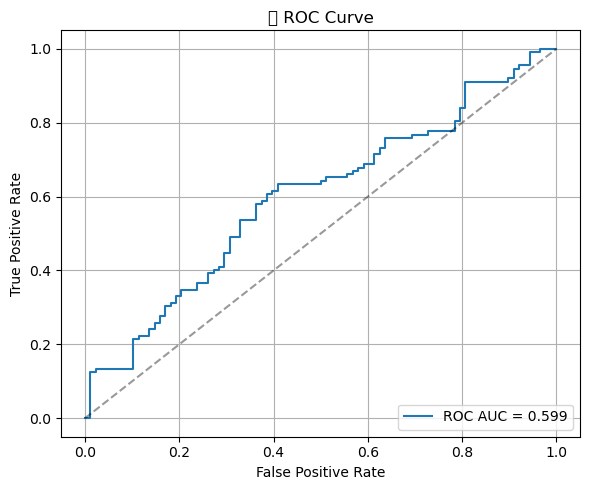

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42))])

In [17]:
# Обучаем и оцениваем логистическую регрессию на выбранных признаках
train_and_evaluate_classifier(X, y, model_name="logreg")

## Random Forest

🔧 Best parameters for rf: {'clf__max_depth': 5, 'clf__n_estimators': 200}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.442     0.989     0.611        88
           1      0.667     0.018     0.035       112

    accuracy                          0.445       200
   macro avg      0.554     0.503     0.323       200
weighted avg      0.568     0.445     0.288       200



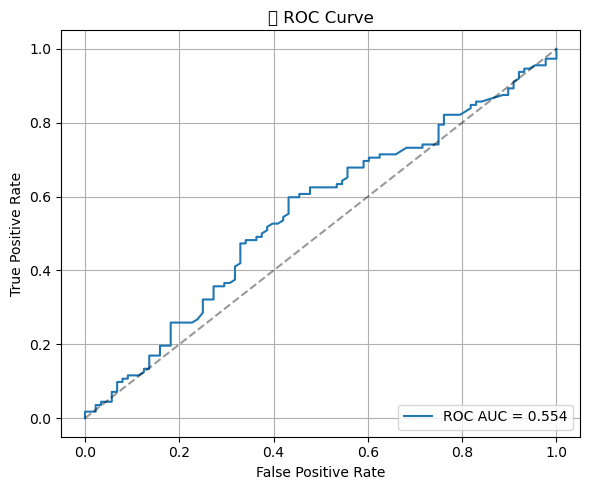

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_depth=5, n_estimators=200,
                                        random_state=42))])

In [18]:
# Обучаем и оцениваем модель случайного леса (масштабирование не требуется)
train_and_evaluate_classifier(X, y, model_name="rf", scale=False)

## XGBoost

🔧 Best parameters for xgb: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.442     1.000     0.613        88
           1      1.000     0.009     0.018       112

    accuracy                          0.445       200
   macro avg      0.721     0.504     0.315       200
weighted avg      0.755     0.445     0.280       200



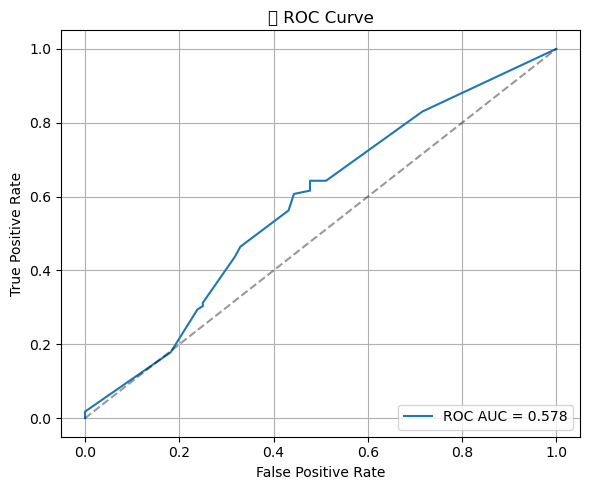

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [19]:
# Обучаем и оцениваем модель XGBoost (без масштабирования признаков)
train_and_evaluate_classifier(X, y, model_name="xgb", scale=False)

# Модели для новостей

### Подготовка для текстовых моделей

In [20]:
# === Предобработка текста (лемматизация на русском через Natasha) ===
segmenter = Segmenter()  # Разделяет текст на предложения и токены
emb = NewsEmbedding()  # Эмбеддинги для новостных текстов
morph_tagger = NewsMorphTagger(emb)  # Определяет часть речи и морфологические признаки
morph_vocab = MorphVocab()  # Используется для лемматизации
stop_words = set(stopwords.words("russian"))  # Русские стоп-слова из NLTK


# === Функция предобработки текста ===
def preprocess_text(text):
    # Приводим к нижнему регистру и удаляем всё, кроме русских букв и пробелов
    text = re.sub(r"[^а-яёА-ЯЁ\\s]", " ", text.lower())

    # Обрабатываем текст с помощью Natasha
    doc = Doc(text)
    doc.segment(segmenter)  # Токенизация
    doc.tag_morph(morph_tagger)  # Морфологическая разметка

    lemmas = []
    for token in doc.tokens:
        # Лемматизируем, если у токена есть морфология
        if token.pos and token.feats:
            lemma = morph_vocab.lemmatize(token.text, token.pos, token.feats)
            # Убираем стоп-слова и слишком короткие леммы
            if lemma not in stop_words and len(lemma) > 2:
                lemmas.append(lemma)

    # Возвращаем текст из лемм
    return " ".join(lemmas)

In [21]:
# Выбираем заголовки новостей и целевую переменную
df_news = df_final[["title", "target"]]

# Применяем предобработку к заголовкам: очистка и лемматизация
df_news["clean_title"] = df_news["title"].apply(preprocess_text)

# Просматриваем первые строки полученного датафрейма
df_news.head()

C:\Users\Cristin\AppData\Local\Temp\ipykernel_12100\1371736760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news["clean_title"] = df_news["title"].apply(preprocess_text)


,title,target,clean_title
2,Глава Генштаба оценил вероятность начала крупн...,0,глава генштаб оценить вероятность начало крупн...
3,Путин назвал подвигом жизнь россиян в 1990-х П...,0,путин назвать подвиг жизнь россиянин путин отв...
12,Генсек ООН заявил о максимальном уровне геопол...,0,генсек оон заявить максимальный уровень геопол...
13,В США объяснили путаницу с выводом войск из Ир...,0,сша объяснить путаница вывод войско ирак сша о...
14,Путин рассказал о попытках помешать отношениям...,0,путин рассказать попытка помешать отношение ро...


In [22]:
# === Инициализация токенизатора и модели BERT от Sberbank ===
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBert-base")
model = AutoModel.from_pretrained("sberbank-ai/ruBert-base")
model.eval()  # Переводим модель в режим инференса (без градиентов)


# === Функция для кодирования длинных текстов чанками ===
def bert_encode_long(texts, max_len=512, stride=256):
    vectors = []
    with torch.no_grad():  # Отключаем градиенты для ускорения и экономии памяти
        for text in tqdm(texts, desc="BERT long embedding"):
            # Токенизация без усечения
            tokens = tokenizer(text, return_tensors="pt", truncation=False)[
                "input_ids"
            ][0]
            # Делим токены на перекрывающиеся чанки
            chunks = [tokens[i : i + max_len] for i in range(0, len(tokens), stride)]
            chunk_vecs = []
            for chunk in chunks:
                input_ids = chunk.unsqueeze(0)
                attention_mask = torch.ones_like(
                    input_ids
                )  # Маска внимания без паддинга
                output = model(input_ids=input_ids, attention_mask=attention_mask)
                cls = output.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS] токен
                chunk_vecs.append(cls)
            # Усредняем вектор по чанкам
            avg_vector = np.mean(chunk_vecs, axis=0)
            vectors.append(avg_vector)
    return np.array(vectors)


# Применяем кодирование к очищенным заголовкам
bert_vectors = bert_encode_long(df_news["clean_title"].tolist())
bert_vectors

# Сохраняем эмбеддинги в датафрейм и объединяем с исходными данными
df_bert = pd.DataFrame(bert_vectors)
df_news = df_news.reset_index(drop=True).join(df_bert)

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

BERT long embedding: 100%|███████████████████████████████████████████████████████████| 803/803 [48:15<00:00,  3.61s/it]


In [23]:
df_news.head()

,title,target,clean_title,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,Глава Генштаба оценил вероятность начала крупн...,0,глава генштаб оценить вероятность начало крупн...,0.927387,0.657644,0.662591,0.198693,-0.177159,0.347346,-0.042795,...,-0.348206,-0.360314,-0.795398,-0.034557,-0.858139,0.126720,0.313326,0.710702,0.629863,0.266697
1,Путин назвал подвигом жизнь россиян в 1990-х П...,0,путин назвать подвиг жизнь россиянин путин отв...,0.665235,0.556451,0.200275,0.617243,-0.221813,0.364381,0.346314,...,-0.152317,-0.257469,-0.794251,0.203919,-0.455761,-0.013108,0.052783,0.585324,0.525603,0.319815
2,Генсек ООН заявил о максимальном уровне геопол...,0,генсек оон заявить максимальный уровень геопол...,0.757399,0.621261,0.427097,0.443571,0.162092,0.083111,0.282668,...,-0.440699,-0.484649,-0.914965,0.190409,-0.915958,0.236564,0.330770,0.415386,0.773412,0.071564
3,В США объяснили путаницу с выводом войск из Ир...,0,сша объяснить путаница вывод войско ирак сша о...,0.904204,0.731903,0.517442,0.096467,-0.086301,0.248869,-0.027504,...,-0.145589,-0.377280,-0.767444,0.149618,-0.799955,0.413097,0.295019,0.573089,0.668646,0.246443
4,Путин рассказал о попытках помешать отношениям...,0,путин рассказать попытка помешать отношение ро...,0.814757,0.677781,0.604034,0.662455,0.136538,0.695319,-0.261533,...,0.050770,-0.618827,-0.764370,0.086603,-0.711771,0.216034,0.437568,0.899350,0.653212,0.012188


### Функция для моделей

In [24]:
# === Универсальная функция обучения модели — поддерживает TF-IDF и BERT-вектора ===
def train_and_evaluate_classifier(
    df, model_name="logreg", use_bert=False, n_test=200, scale=True, random_state=42
):
    # Выбор признаков: либо BERT-вектора (768 признаков), либо текст для TF-IDF
    if use_bert:
        X = df.iloc[:, -768:]  # Используем последние 768 колонок как эмбеддинги
    else:
        X = df["clean_title"]  # Используем текст для TF-IDF

    # Целевая переменная
    y = df["target"]

    # Делим данные на обучающую и тестовую выборки по времени
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    # Выбор модели и сетки параметров для GridSearch
    if model_name == "logreg":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
        param_grid = {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]}
    elif model_name == "rf":
        model = RandomForestClassifier(random_state=random_state)
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5, 10],
        }
    elif model_name == "xgb":
        model = XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=random_state
        )
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.01, 0.1],
        }
    else:
        raise ValueError("Модель должна быть одной из: 'logreg', 'rf', 'xgb'")

    # Сборка пайплайна:
    # для TF-IDF добавляем векторизацию, для BERT — масштабирование (по желанию)
    steps = []
    if not use_bert:
        steps.append(("tfidf", TfidfVectorizer()))
    elif scale:
        steps.append(("scaler", StandardScaler()))

    steps.append(("clf", model))
    pipe = Pipeline(steps)

    # Обучение модели с подбором параметров
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Предсказания и вероятности для тестовой выборки
    y_pred = grid.best_estimator_.predict(X_test)
    y_score = grid.best_estimator_.predict_proba(X_test)[:, 1]

    # Вывод лучших параметров и метрик модели
    print(f"\n🔧 Best parameters for {model_name}:", grid.best_params_)
    evaluate_classifier_metrics(y_test, y_pred, y_score)

    return grid.best_estimator_

## TF-IDF + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 0.01, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        88
           1      0.560     1.000     0.718       112

    accuracy                          0.560       200
   macro avg      0.280     0.500     0.359       200
weighted avg      0.314     0.560     0.402       200



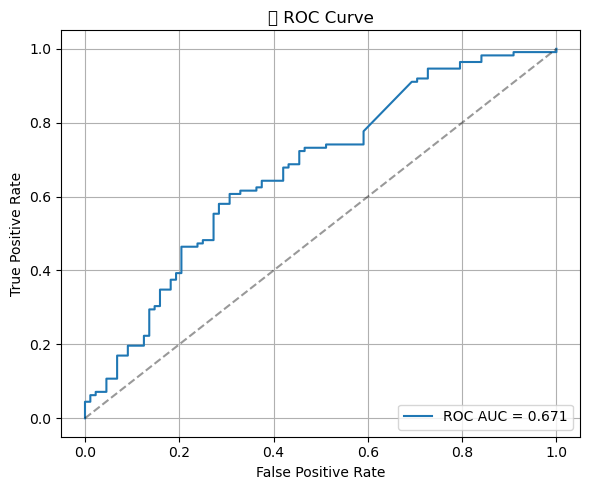

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42))])

In [25]:
# Обучаем логистическую регрессию на TF-IDF векторах заголовков
train_and_evaluate_classifier(df_news, model_name="logreg")

## BERT + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 0.1, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.506     0.443     0.473        88
           1      0.602     0.661     0.630       112

    accuracy                          0.565       200
   macro avg      0.554     0.552     0.551       200
weighted avg      0.560     0.565     0.561       200



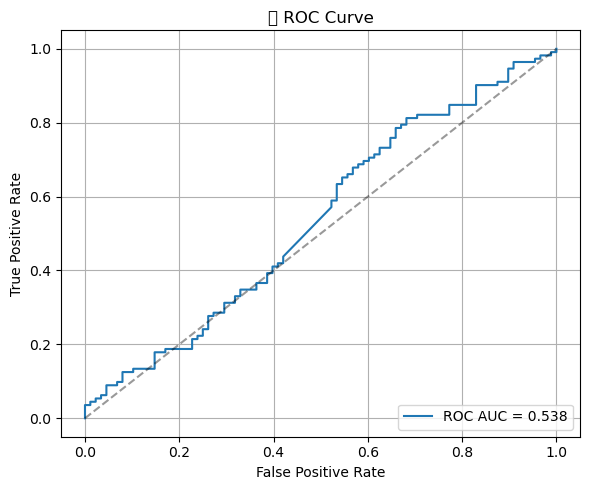

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42))])

In [26]:
# Обучаем логистическую регрессию на BERT-векторах заголовков
train_and_evaluate_classifier(df_news, model_name="logreg", use_bert=True)

## TF-IDF + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 3, 'clf__n_estimators': 1000}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.500     0.011     0.022        88
           1      0.561     0.991     0.716       112

    accuracy                          0.560       200
   macro avg      0.530     0.501     0.369       200
weighted avg      0.534     0.560     0.411       200



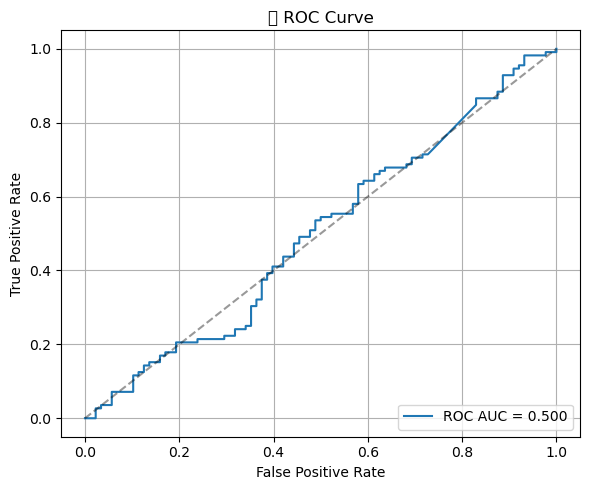

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 RandomForestClassifier(max_depth=3, n_estimators=1000,
                                        random_state=42))])

In [27]:
# Обучаем модель случайного леса на TF-IDF векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="rf", scale=False)

## BERT + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 10, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.458     0.375     0.412        88
           1      0.570     0.652     0.608       112

    accuracy                          0.530       200
   macro avg      0.514     0.513     0.510       200
weighted avg      0.521     0.530     0.522       200



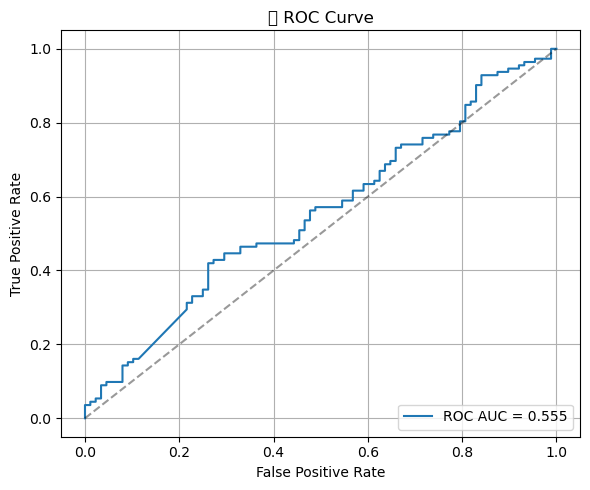

Pipeline(steps=[('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [28]:
# Обучаем модель случайного леса на BERT-векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="rf", use_bert=True, scale=False)

## TF-IDF + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 500}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.507     0.398     0.446        88
           1      0.595     0.696     0.642       112

    accuracy                          0.565       200
   macro avg      0.551     0.547     0.544       200
weighted avg      0.557     0.565     0.556       200



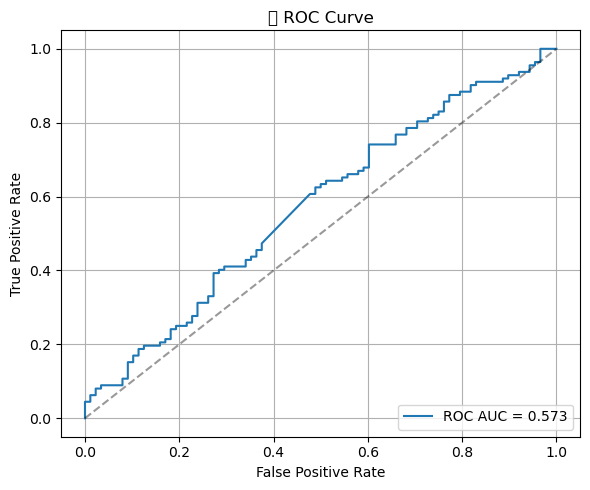

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [29]:
# Обучаем модель XGBoost на TF-IDF векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="xgb", scale=False)

## BERT + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 200}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.441     0.341     0.385        88
           1      0.561     0.661     0.607       112

    accuracy                          0.520       200
   macro avg      0.501     0.501     0.496       200
weighted avg      0.508     0.520     0.509       200



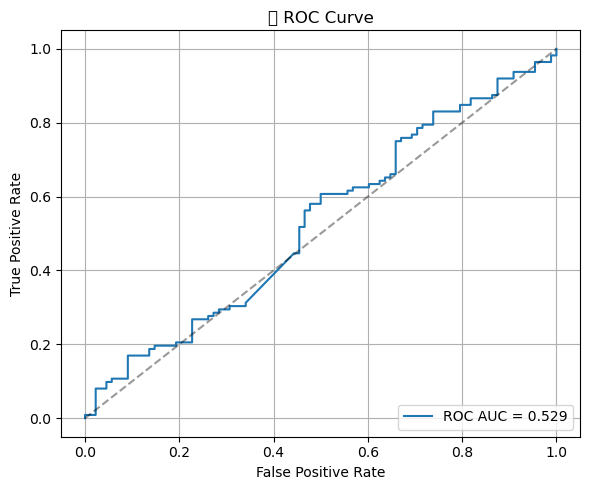

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [30]:
# Обучаем модель XGBoost на BERT-векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="xgb", use_bert=True, scale=False)

# Мультимодальные модели

In [31]:
# Объединяем временные признаки (лаговые и SMA) с текстовыми признаками из новостей
# Пропускаем первые 5 строк в новостях — они были отброшены ранее из-за расчётов скользящих метрик
df_time_news = df_time.join(df_news.loc[5:, "clean_title":].reset_index(drop=True))

# Приводим имена всех колонок к строковому типу (нужно, если были числовые индексы)
df_time_news.columns = df_time_news.columns.astype(str)

# Просматриваем первые строки итогового датафрейма
df_time_news.head()

,Close,target,lag_1,lag_2,lag_3,sma_5,delta_week,clean_title,0,1,...,758,759,760,761,762,763,764,765,766,767
0,60.9418,1,60.9418,61.5955,61.9555,61.73192,-1.6490,иран заявить готовность отправить черный ящик ...,0.932390,0.681382,...,-0.017963,-0.508813,-0.727569,0.208639,-0.631001,0.292843,0.433013,0.872618,0.515522,0.166606
1,61.2725,1,61.2725,60.9418,61.5955,61.51042,-1.1075,макрон путин решить сохранить ядерный сделка и...,0.650808,0.798177,...,-0.276133,-0.411356,-0.768324,0.122024,-0.679617,-0.012070,0.319459,0.709141,0.741609,0.082505
2,61.4780,1,61.4780,61.2725,60.9418,61.44866,-0.3088,россия ответить германии заявление убить берли...,1.162181,0.638273,...,-0.393887,-0.415498,-0.726309,0.109639,-0.549729,-0.094339,0.274860,0.782627,0.694888,0.136957
3,61.6000,1,61.6000,61.4780,61.2725,61.37756,-0.3555,боевик попытаться атаковать российский авиабаз...,1.038046,0.637571,...,-0.455723,-0.282205,-1.121767,0.254938,-0.669756,0.108217,0.359359,0.688683,0.701896,0.256569
4,62.0285,1,62.0285,61.6000,61.4780,61.46416,0.4330,сенатор сша научить бороться назойливый журнал...,0.889682,0.708258,...,-0.390100,-0.352987,-1.124415,0.129927,-0.604181,-0.008546,0.213744,0.915043,0.794599,0.205324


In [32]:
# === Обучение мультимодальной модели: текст (TF-IDF/BERT) + числовые признаки ===
def train_multimodal_classifier(
    df, model_name="logreg", use_bert=False, n_test=200, random_state=42
):
    text_col = "clean_title"  # Название колонки с текстом
    num_cols = ["lag_1", "lag_2", "lag_3", "sma_5", "delta_week"]  # Числовые признаки

    y = df["target"]  # Целевая переменная

    # Разделяем текстовую часть на train/test
    if use_bert:
        X_text = df.iloc[:, -768:]  # Если BERT — используем последние 768 колонок
        X_text_train, X_text_test = X_text[:-n_test], X_text[-n_test:]
    else:
        X_text = df[[text_col]]  # Если TF-IDF — оставляем текстовую колонку
        X_text_train, X_text_test = X_text[:-n_test], X_text[-n_test:]

    # Разделяем числовые признаки на train/test
    X_num = df[num_cols]
    X_num_train, X_num_test = X_num[:-n_test], X_num[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    # Выбор модели и сетки параметров для GridSearch
    if model_name == "logreg":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
        param_grid = {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]}
    elif model_name == "rf":
        model = RandomForestClassifier(random_state=random_state)
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5, 10],
        }
    elif model_name == "xgb":
        model = XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=random_state
        )
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.01, 0.1],
        }
    else:
        raise ValueError("Модель должна быть одной из: 'logreg', 'rf', 'xgb'")

    # Обработка признаков для BERT: числовые — масштабируем, текстовые — как есть
    if use_bert:
        preprocessor = ColumnTransformer(
            [("num", StandardScaler(), num_cols)], remainder="passthrough"
        )
        X_train = pd.concat(
            [X_text_train.reset_index(drop=True), X_num_train.reset_index(drop=True)],
            axis=1,
        )
        X_test = pd.concat(
            [X_text_test.reset_index(drop=True), X_num_test.reset_index(drop=True)],
            axis=1,
        )
    else:
        # Обработка TF-IDF + масштабирование числовых признаков
        text_transformer = Pipeline([("tfidf", TfidfVectorizer())])
        num_transformer = Pipeline([("scaler", StandardScaler())])

        preprocessor = ColumnTransformer(
            [("text", text_transformer, text_col), ("num", num_transformer, num_cols)]
        )

        X_train = pd.concat([X_text_train, X_num_train], axis=1)
        X_test = pd.concat([X_text_test, X_num_test], axis=1)

    # Сборка полного пайплайна: препроцессор + классификатор
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", model)])

    # Поиск лучших параметров и обучение модели
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Предсказания и вероятности
    y_pred = grid.best_estimator_.predict(X_test)
    y_score = grid.best_estimator_.predict_proba(X_test)[:, 1]

    # Вывод лучших параметров и метрик
    print(f"\n🔧 Best parameters for {model_name}:", grid.best_params_)
    evaluate_classifier_metrics(y_test, y_pred, y_score)

    return grid.best_estimator_

## TF-IDF + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 0.01, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.440     1.000     0.611        88
           1      0.000     0.000     0.000       112

    accuracy                          0.440       200
   macro avg      0.220     0.500     0.306       200
weighted avg      0.194     0.440     0.269       200



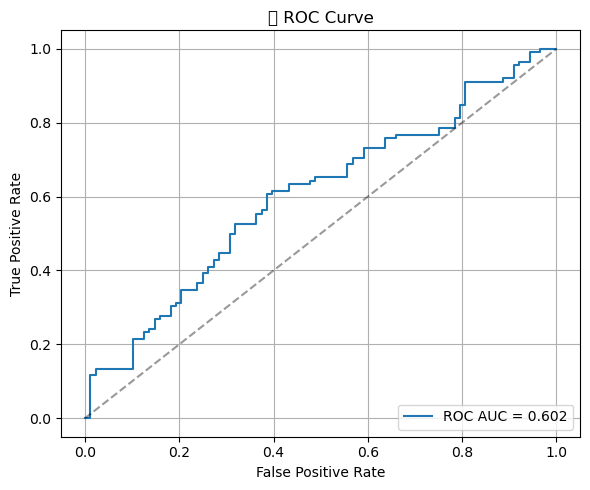

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'clean_title'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42))])

In [33]:
# Обучаем логистическую регрессию на TF-IDF + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="logreg")

## BERT + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 0.01, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.441     0.977     0.608        88
           1      0.600     0.027     0.051       112

    accuracy                          0.445       200
   macro avg      0.521     0.502     0.330       200
weighted avg      0.530     0.445     0.296       200



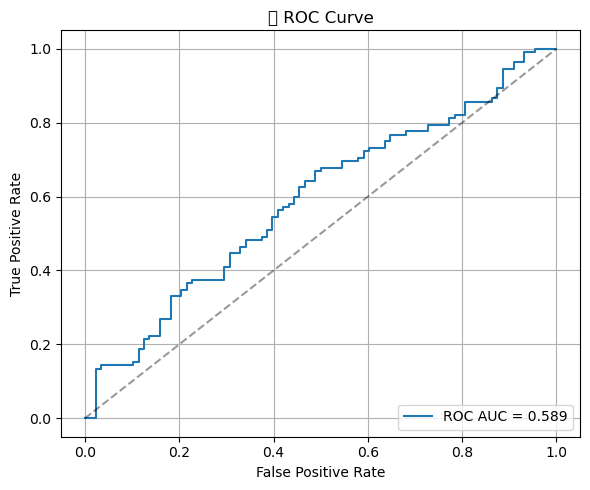

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42))])

In [34]:
# Обучаем логистическую регрессию на BERT-векторах + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="logreg", use_bert=True)

## TF-IDF + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 10, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.457     0.420     0.438        88
           1      0.571     0.607     0.589       112

    accuracy                          0.525       200
   macro avg      0.514     0.514     0.513       200
weighted avg      0.521     0.525     0.522       200



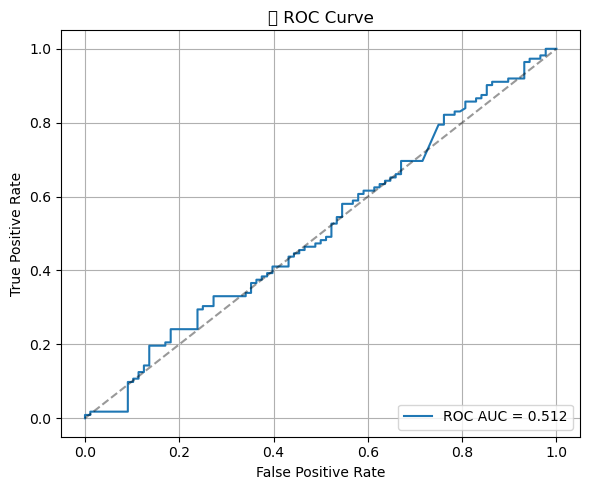

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'clean_title'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [35]:
# Обучаем модель случайного леса на TF-IDF + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="rf")

## BERT + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 3, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.491     0.625     0.550        88
           1      0.625     0.491     0.550       112

    accuracy                          0.550       200
   macro avg      0.558     0.558     0.550       200
weighted avg      0.566     0.550     0.550       200



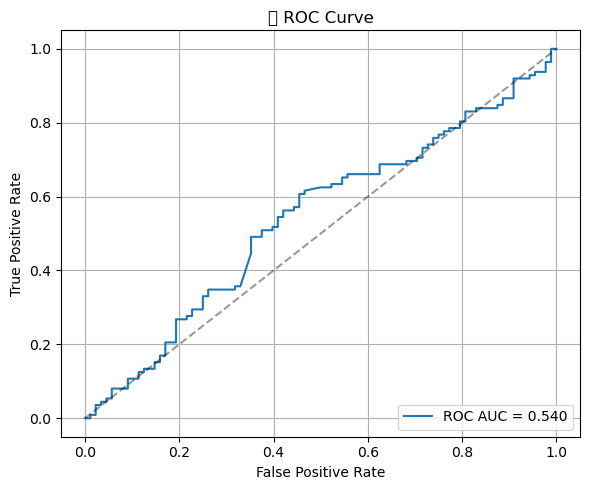

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf', RandomForestClassifier(max_depth=3, random_state=42))])

In [36]:
# Обучаем модель случайного леса на BERT-векторах + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="rf", use_bert=True)

## TF-IDF + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 500}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.481     0.727     0.579        88
           1      0.642     0.384     0.480       112

    accuracy                          0.535       200
   macro avg      0.561     0.556     0.530       200
weighted avg      0.571     0.535     0.524       200



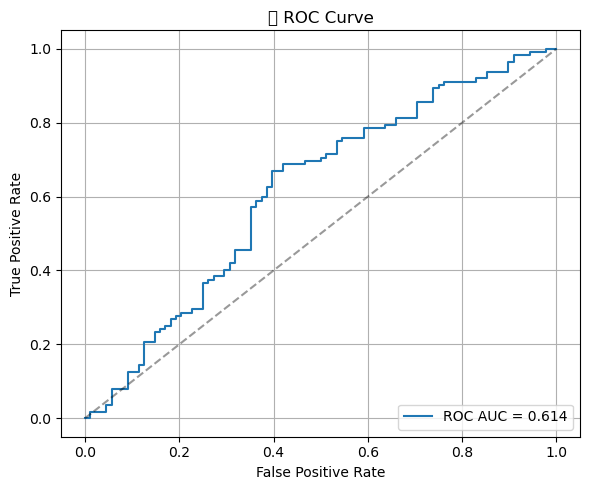

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'clean_title'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               col...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [37]:
# Обучаем модель XGBoost на TF-IDF + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="xgb")

## BERT + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.459     0.636     0.533        88
           1      0.590     0.411     0.484       112

    accuracy                          0.510       200
   macro avg      0.524     0.524     0.509       200
weighted avg      0.532     0.510     0.506       200



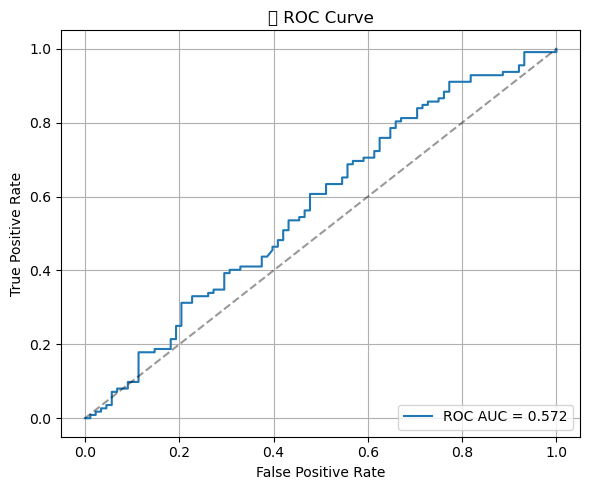

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categoric...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [38]:
# Обучаем модель XGBoost на BERT-векторах + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="xgb", use_bert=True)

In [39]:
df_news.to_csv("df_news_clean.csv", index=False)